# Task for Today  

***

## Food Image Classification  

Given *images of 101 different foods*, let's try to classifify the **food** present in a given image.

We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.

# Getting Started

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications import mobilenet_v3


In [5]:
image_dir = Path('../recipes gen/images')

# Creating File DataFrame

In [6]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [7]:
image_df

,Filepath,Label
0,..\recipes gen\images\paella\1769909.jpg,paella
1,..\recipes gen\images\steak\2815172.jpg,steak
2,..\recipes gen\images\bread_pudding\272991.jpg,bread_pudding
3,..\recipes gen\images\waffles\1854304.jpg,waffles
4,..\recipes gen\images\french_toast\3009499.jpg,french_toast
...,...,...
10095,..\recipes gen\images\croque_madame\3389786.jpg,croque_madame
10096,..\recipes gen\images\poutine\227190.jpg,poutine
10097,..\recipes gen\images\breakfast_burrito\790446...,breakfast_burrito
10098,..\recipes gen\images\guacamole\2979136.jpg,guacamole


In [8]:
image_df['Label'].value_counts()

Label
paella                  100
red_velvet_cake         100
baby_back_ribs          100
shrimp_and_grits        100
cup_cakes               100
                       ... 
takoyaki                100
pad_thai                100
fried_rice              100
strawberry_shortcake    100
apple_pie               100
Name: count, Length: 101, dtype: int64

# Train-Test Split

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Creating Generators

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=mobilenet_v3.preprocess_input,
    validation_split=0.3,
    rotation_range=20,          # Rotate images up to 20 degrees
    width_shift_range=0.2,      # Shift images horizontally up to 20% of the width
    height_shift_range=0.2,     # Shift images vertically up to 20% of the height
    shear_range=0.2,            # Shear images up to 20 degrees
    zoom_range=0.2,             # Zoom images up to 20%
    horizontal_flip=True,       # Allow horizontal flipping of images
    fill_mode='nearest'         # Fill missing pixels using the 'nearest' method
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=mobilenet_v3.preprocess_input
)


In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4949 validated image filenames belonging to 101 classes.
Found 2121 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


# Modeling

In [12]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

# Training

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
155/155 [==============================] - 95s 572ms/step - loss: 3.8688 - accuracy: 0.1416 - val_loss: 2.9784 - val_accuracy: 0.2749
Epoch 2/20
155/155 [==============================] - ETA: 0s - loss: 2.4955 - accuracy: 0.3696

# Results

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 40.23%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

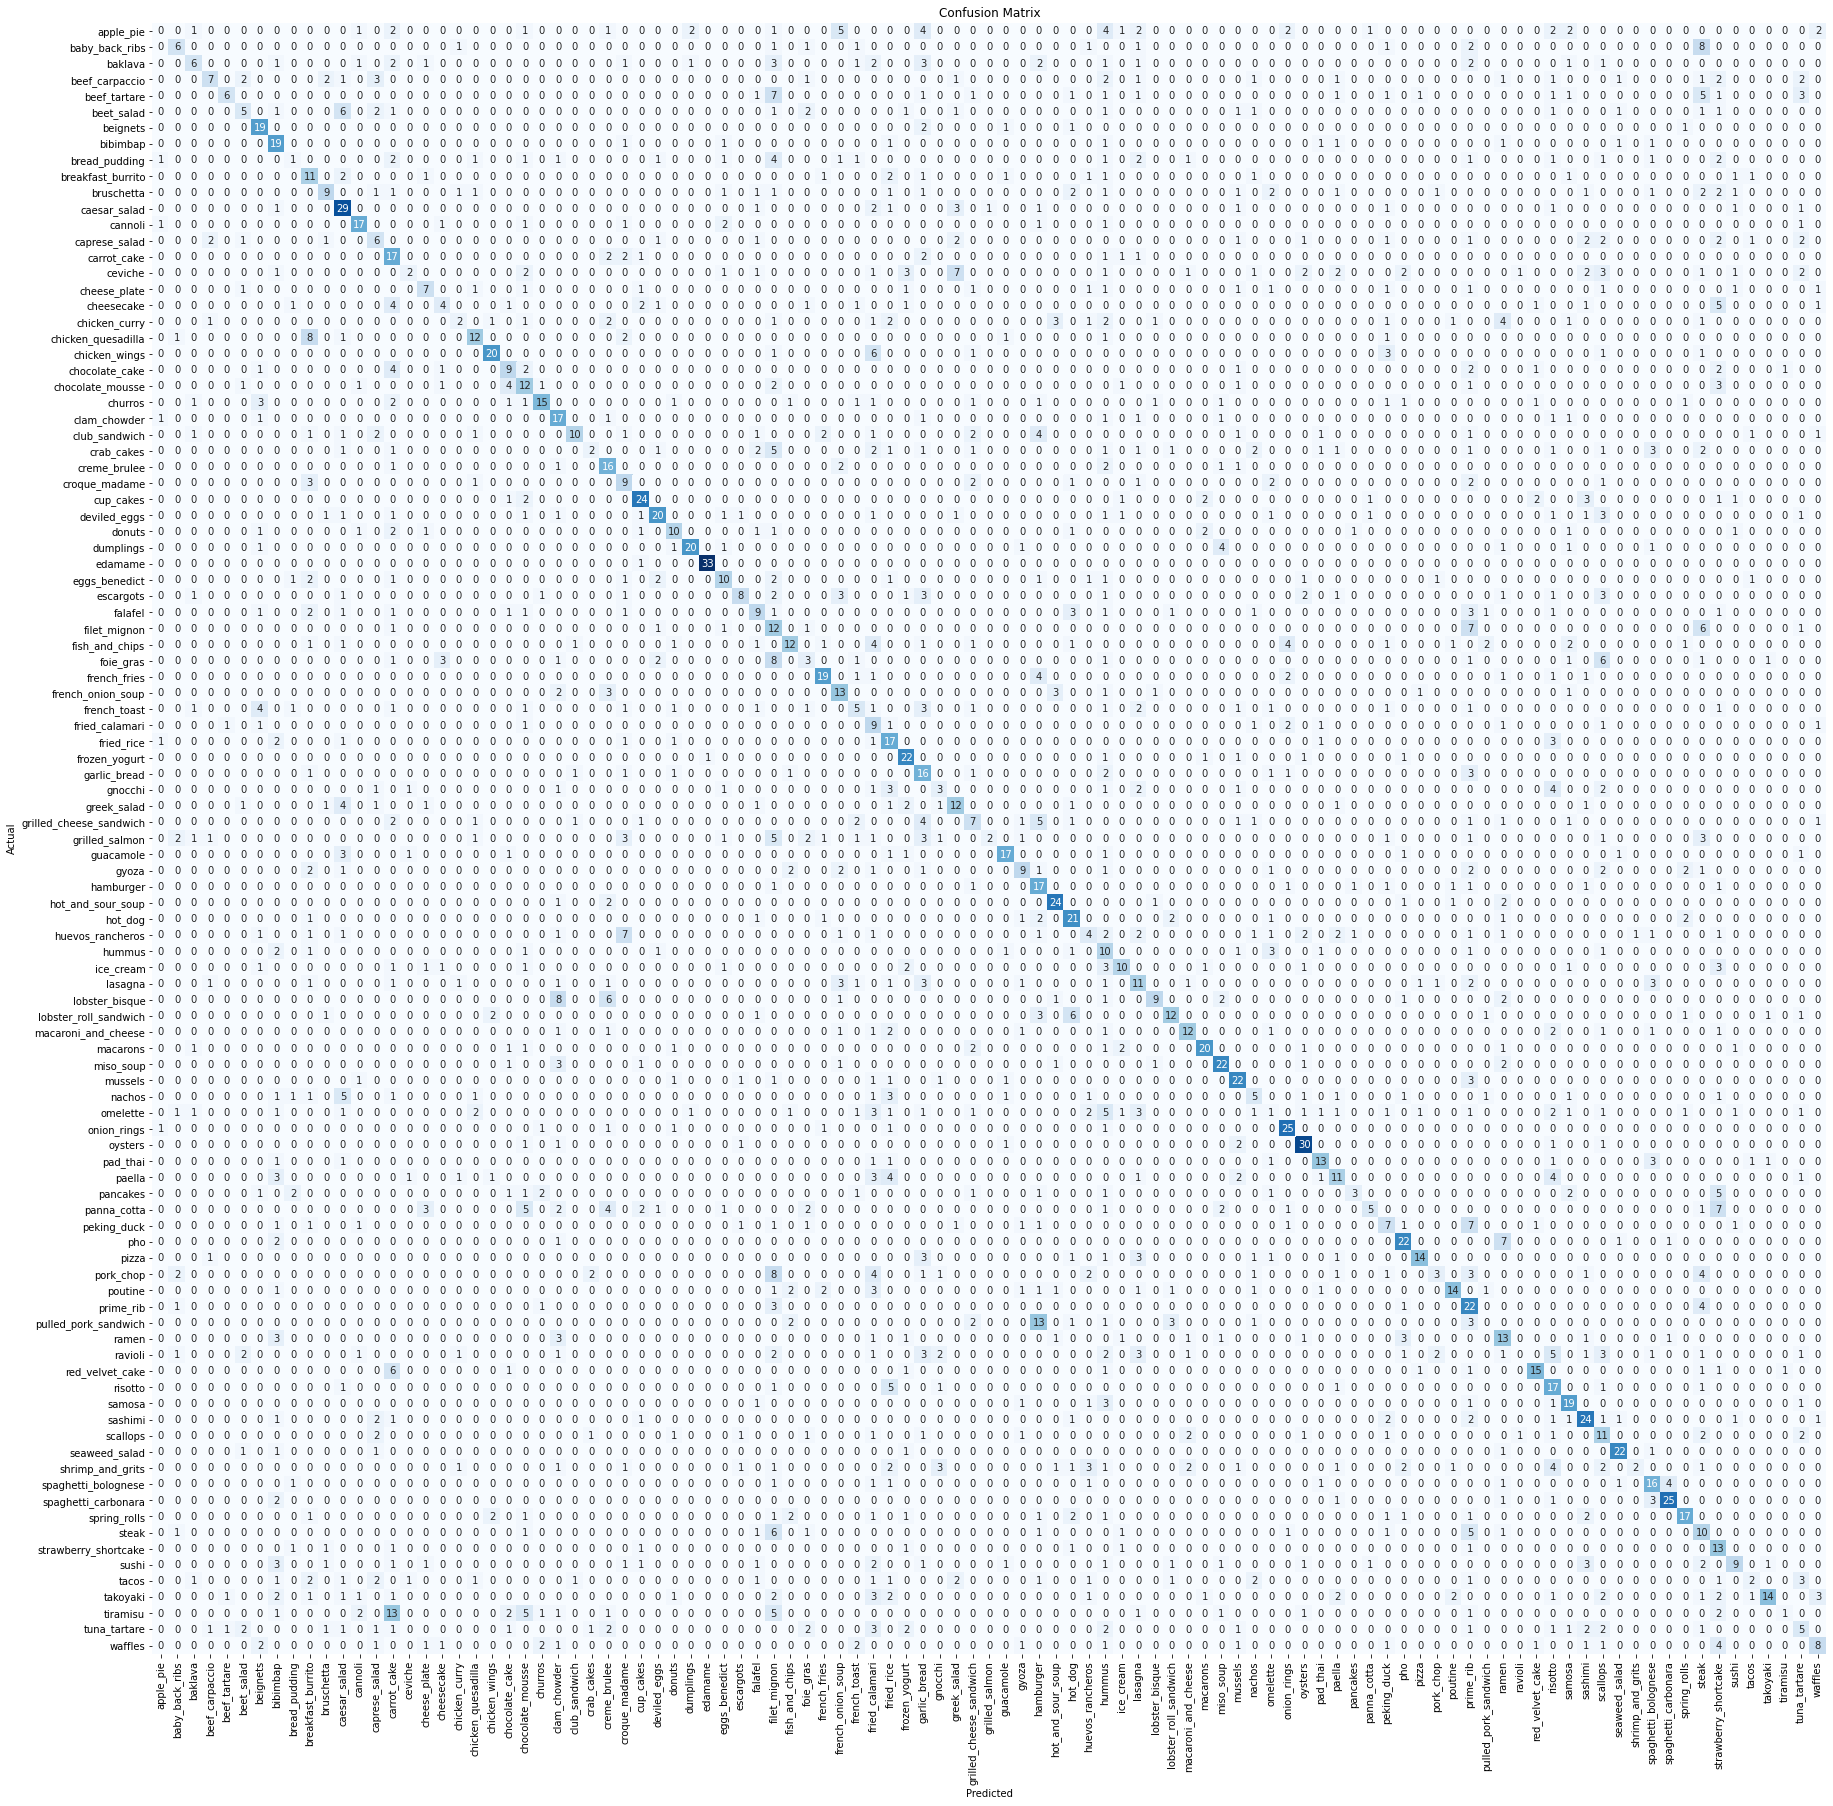

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.00      0.00      0.00        34
         baby_back_ribs       0.40      0.26      0.32        23
                baklava       0.40      0.20      0.27        30
         beef_carpaccio       0.50      0.23      0.32        30
           beef_tartare       0.67      0.18      0.29        33
             beet_salad       0.31      0.19      0.23        27
               beignets       0.51      0.79      0.62        24
               bibimbap       0.37      0.68      0.48        28
          bread_pudding       0.11      0.04      0.06        25
      breakfast_burrito       0.27      0.44      0.33        25
             bruschetta       0.50      0.27      0.35        33
           caesar_salad       0.44      0.66      0.53        44
                cannoli       0.63      0.65      0.64        26
          caprese_salad       0.24      0.

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/35iRdqY01co